In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression
import torch
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components


In [2]:
from datetime import datetime, timedelta
import datetime as dt 


In [3]:
%load_ext autoreload
%autoreload 2

<class 'numpy.ndarray'>


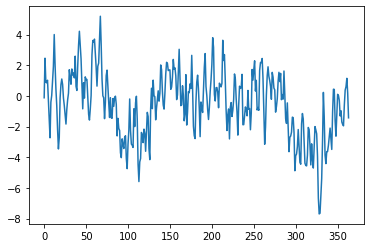

In [21]:
# make the data
n = 365 # hourly for 1 year 

x0 = np.random.normal(0, 1, n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X = np.vstack([x0, x1]).transpose()
   
    

eta = np.random.normal(0, 1.0, n)

rho = [0.95, -0.25,0.25]
beta = [0.00, -0.00]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + rho[2]*y[i-7] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]

     
#plt.plot(y)
plt.plot(y[1:500])
print(type(X))

In [22]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:(n+1)]
hours = [dt.datetime.strptime(hour, "%Y-%m-%d %H:%M") for hour in hours]


In [23]:
df = pd.DataFrame(X, columns=['a1', 'a2'])
df['hours'] = hours
df['y'] = y

In [24]:
df_train = df.iloc[0:180,:]
df_test = df.iloc[180:n,:]


In [25]:
mod = ARMA(
        #regressor_col=['a1', 'a2'],
        lm_first=0,
        estimator='stan-mcmc',
        date_col = 'hours',
        response_col = 'y',
        num_of_ar_lags = 3,
        ar_lags = [1,2,7],
        #num_of_ma_lags = 1,
        #ma_lags = [1] ,
    num_warmup=2000,
    num_sample=2000,

)

In [26]:
mod.fit(df_train)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):500 and samples(per chain):500.


In [27]:
pred = mod.predict(df)

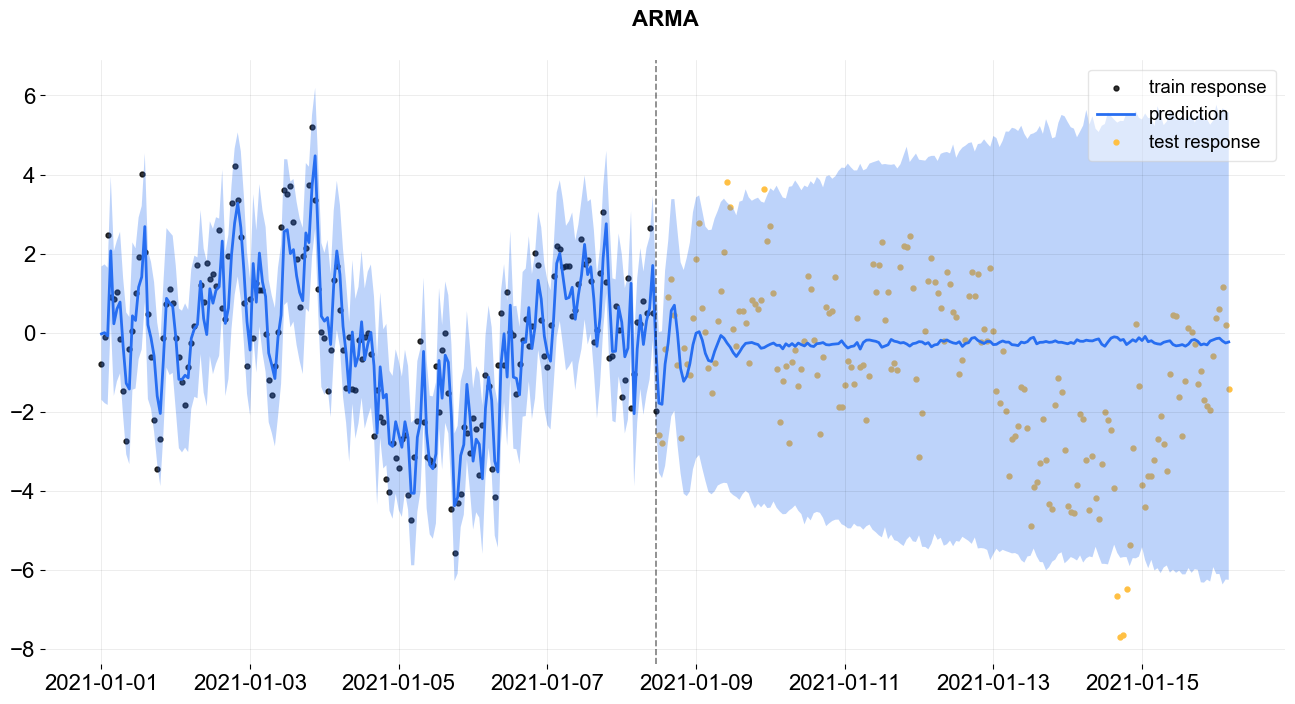

In [28]:

_ = plot_predicted_data(df_train, pred, date_col = 'hours', actual_col = 'y', title='ARMA', test_actual_df = df_test)

In [ ]:
np.std(pred.iloc[8700:n,3]-df_test['y'])

In [ ]:
mod.get_regression_coefs

In [ ]:
1.0/(1.0-0.5**2)